# Project 1

### Step 1: Run pseudoexperiments for 10000 events

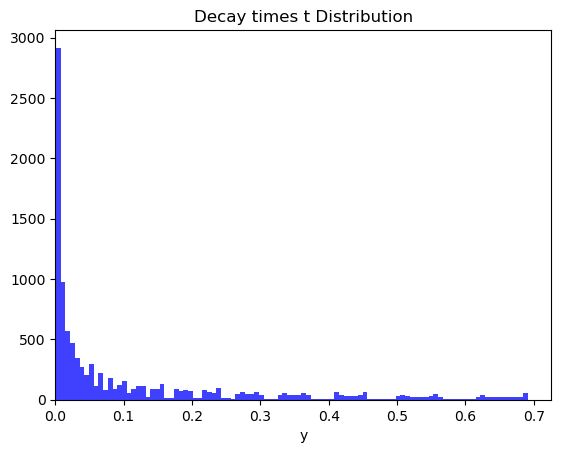

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL
from scipy.stats import norm


# define pdf (not normalised?)
def pdf(t, tau, dm, V):
    return (1 + V*np.sin(dm*t))*np.exp(-t/tau)


# nominal parameter values
tau_nom = 1.5e-6
dm_nom = 20e6
V_nom = 0.1 # takes 0 if universe non-symmetric


# generate data
bounds = [5e-7, 1e-5] # range of t values in which to generate data

t = np.linspace(bounds[0], bounds[1], 10000) # generate decay times t within bounds
y = pdf(t, tau_nom, dm_nom, V_nom) # input t-values into pdf


# plot data
plt.hist(y, bins=100, color="blue", alpha = 0.75) # plot histogram of pdf

plt.xlim(0,)
plt.xlabel("y")
plt.title("Decay times t Distribution")
plt.show()

